In [1]:
import wandb
import os
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.font_manager as fm
import scipy
fm.fontManager.addfont('../times.ttf')
fm.fontManager.addfont('../times_Italic.ttf')
results = pd.read_csv("./right.csv")
results["win_rate"] = results["win_rate"] / 100


plt.rcParams.update({"font.size": 36, "font.family": "Times New Roman"})
plt.rcParams['text.usetex'] = False
# plt.rcParams['mathtext.fontset'] = "custom"
# plt.rcParams['mathtext.it'] = "Times New Roman"
# plt.rcParams['mathtext.rm'] = "Times New Roman"
# plt.rcParams['font.family'] = "Times New Roman"
# plt.rc("text.latex", preamble=r"\usepackage{times}")

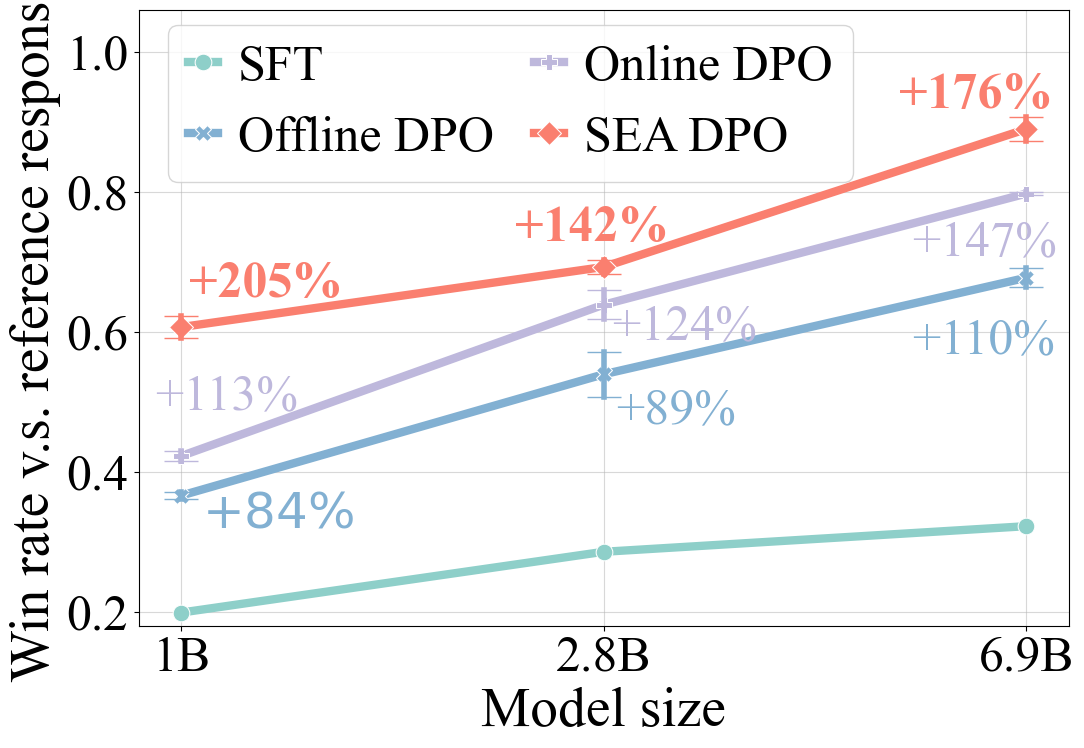

In [2]:
# sns.set_theme(style="white", rc={"font.family": "Times New Roman"})
hue_order = [
    "SFT",
    "Offline",
    "Online",
    "Sea",
]
methods_to_color = {
    "SFT": "#8ECFC9",
    "Offline": "#82b0d2",
    "Online": "#beb8dc",
    "Sea": "#fa7f6f",
}
methods_to_labels= {
    "SFT": "SFT",
    "Offline": "Offline DPO",
    "Online": "Online DPO",
    "Sea": "SEA DPO",
}
methods_to_markers = {
    "SFT": "o",
    "Offline": "X",
    "Online": "P",
    "Sea": "D",
}
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=results, x="scale", y="win_rate", linewidth=6, markersize=12, hue="method", hue_order=hue_order, style="method", palette=methods_to_color, dashes=False, markers=methods_to_markers, err_style="bars", errorbar=("se", 2), err_kws={"linewidth": 4, "capsize": 12})
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.4, 0.68), ncol=2, title=None, 
    frameon=True,
    labels=[methods_to_labels[k] for k in hue_order],
    handletextpad=0.4,
    handlelength=0.6,
    columnspacing=0.8
)
# plt.title("Win rate against reference responses\n(judged by preference oracle)", fontsize=48, y=1.0, pad=110)
plt.ylim(0.18, 1.06)
plt.yticks([0.2, 0.4,0.6, 0.8, 1.0])
plt.xlabel("Model size", fontsize=40)
plt.ylabel("Win rate v.s. reference responses", fontsize=40)
plt.text(0.05, 0.32, r"$+84\mathrm{\%}$", color=methods_to_color["Offline"])
plt.text(1.03, 0.47, "+89%", color=methods_to_color["Offline"])
plt.text(1.73, 0.57, "+110%", color=methods_to_color["Offline"])

plt.text(-0.06, 0.49, "+113%", color=methods_to_color["Online"])
plt.text(1.02, 0.59, "+124%", color=methods_to_color["Online"])
plt.text(1.73, 0.71, "+147%", color=methods_to_color["Online"])

plt.text(0.02, 0.65, "+205%", color=methods_to_color["Sea"], weight='bold')
plt.text(0.79, 0.73, "+142%", color=methods_to_color["Sea"], weight='bold')
plt.text(1.7, 0.92, "+176%", color=methods_to_color["Sea"], weight='bold')

plt.grid(True, which="both", ls="-", c="0.7", alpha=0.5)
# sns.despine()

fig = ax.get_figure()
fig.savefig("fig1_left.pdf", bbox_inches="tight")

In [17]:
mean = results.groupby(["method", "scale"])["win_rate"].apply(lambda x: np.mean(x))
mean

method   scale
Offline  1B       0.365800
         2.8B     0.539167
         6.9B     0.677100
Online   1B       0.422267
         2.8B     0.638533
         6.9B     0.797333
SFT      1B       0.198700
         2.8B     0.285600
         6.9B     0.322200
Sea      1B       0.606533
         2.8B     0.692500
         6.9B     0.889500
Name: win_rate, dtype: float64

In [18]:
mean.to_numpy() / pd.concat([mean["SFT"]] * 4).to_numpy() - 1

array([0.84096628, 0.88783847, 1.10148976, 1.12514679, 1.23576097,
       1.47465342, 0.        , 0.        , 0.        , 2.05250797,
       1.42471989, 1.76070764])

In [19]:
data_paths = [
    # DPO
    ## 1B STF
    "skyworkrm_dpo_offline_0921T01:12",
    "skyworkrm_dpo_offline_0921T00:15",
    "skyworkrm_dpo_offline_0917T07:16",
    ## 1B Offline
    "skyworkrm_dpo_offline_0921T01:12",
    "skyworkrm_dpo_offline_0921T00:15",
    "skyworkrm_dpo_offline_0917T07:16",
    ## 1B Online passive
    "skyworkrm_dpo_online_0920T16:13",
    "skyworkrm_dpo_online_0920T15:15",
    "skyworkrm_dpo_online_0917T08:29",
    # 1B Online sea
    "skyworkrm_dpo_sea_0925T15:53",
    "skyworkrm_dpo_sea_0925T11:49",
    "skyworkrm_dpo_sea_0925T07:47",
    # 1B XPO
    "skyworkrm_xpo_0921T00:24",
    "skyworkrm_xpo_0920T15:11",
    "skyworkrm_xpo_0917T07:41",
    # 1B APL
    "skyworkrm_apl_0921T00:20",
    "skyworkrm_apl_0920T15:13",
    "skyworkrm_apl_0917T07:44",
    ]

In [20]:
features_of_interest = ["eval/rm_win_rate_prob", "misc/query_step"]

In [21]:
# # Download

# api = wandb.Api()

# runs = api.runs("lkevinzc/ellm_simpo")
# data_list = []
# cfg_list = []

# os.makedirs("./fig1_data", exist_ok=True)
# for run in tqdm.tqdm(runs):
#     cfg = run.config
#     if run.name in data_paths:
#         print(run.name)
#         name = run.name
#         if not os.path.exists(f"fig1_data/{name}.csv"):
#             data = run.history(keys=features_of_interest)
#             data["seed"] = cfg["seed"]
#             data["run_name"] = cfg["wandb_run_name"]
#             data.to_csv(f"fig1_data/{name}.csv")


In [22]:
import pandas as pd
import glob
import functools

In [29]:
fns = glob.glob("./fig1_data/*.csv")
dfs = [pd.read_csv(fn, index_col=0) for fn in fns]
df = pd.concat(dfs)
df

,_step,eval/rm_win_rate_prob,misc/query_step,seed,run_name
0,0,0.498840,0,2418139142,skyworkrm_dpo_sea
1,20,0.518882,1960,2418139142,skyworkrm_dpo_sea
2,50,0.613672,4600,2418139142,skyworkrm_dpo_sea
3,80,0.665837,7240,2418139142,skyworkrm_dpo_sea
4,110,0.719324,9880,2418139142,skyworkrm_dpo_sea
...,...,...,...,...,...
16,320,0.757781,40960,1816070529,skyworkrm_xpo
17,340,0.765336,43520,1816070529,skyworkrm_xpo
18,360,0.765762,46080,1816070529,skyworkrm_xpo
19,380,0.768148,48640,1816070529,skyworkrm_xpo


In [30]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)  # Save it
        last = smoothed_val  # Anchor the last smoothed value

    return smoothed
def _smooth(df, smooth_weight):
    for feature in features_of_interest:
        df[feature] = smooth(list(df[feature]), smooth_weight)
    return df

plot_data = df.groupby(["seed", "run_name"], group_keys=False).apply(
        functools.partial(_smooth, smooth_weight=0)
    )

/tmp/ipykernel_146033/2562813459.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_data = df.groupby(["seed", "run_name"], group_keys=False).apply(


In [31]:
mean = df.groupby(["run_name", "misc/query_step"])["eval/rm_win_rate_prob"].apply(lambda x: np.mean(x))

In [32]:
# "skyworkrm_dpo_offline", 
method = ["skyworkrm_dpo_online", "skyworkrm_dpo_sea", "skyworkrm_xpo", "skyworkrm_apl"]
ref = "skyworkrm_dpo_online"
ref_interp_fn = scipy.interpolate.interp1d(mean[ref].values, mean[ref].keys())
method_sample_complexity = {}
df = []
# sweep = np.linspace(mean[ref].values.min(), mean[ref].values.max(), 100)
sweep = mean[ref].values[::2]
for m in method:
    if m not in method_sample_complexity:
        method_sample_complexity[m] = []
    interp_fn = scipy.interpolate.interp1d(mean[m].values, mean[m].keys())
    for i, wr in enumerate(sweep):
        if i == 0:
                df.append({
                "method": m,
                "ref_query": 0,
                "method_query": 0
            })
        if wr >= interp_fn.x.min() and wr <= interp_fn.x.max():
            ref_sample = ref_interp_fn(wr)
            m_sample = interp_fn(wr)
            
            df.append({
                "method": m,
                "ref_query": ref_sample.item(),
                "method_query": m_sample.item()
            })
df = pd.DataFrame(df)

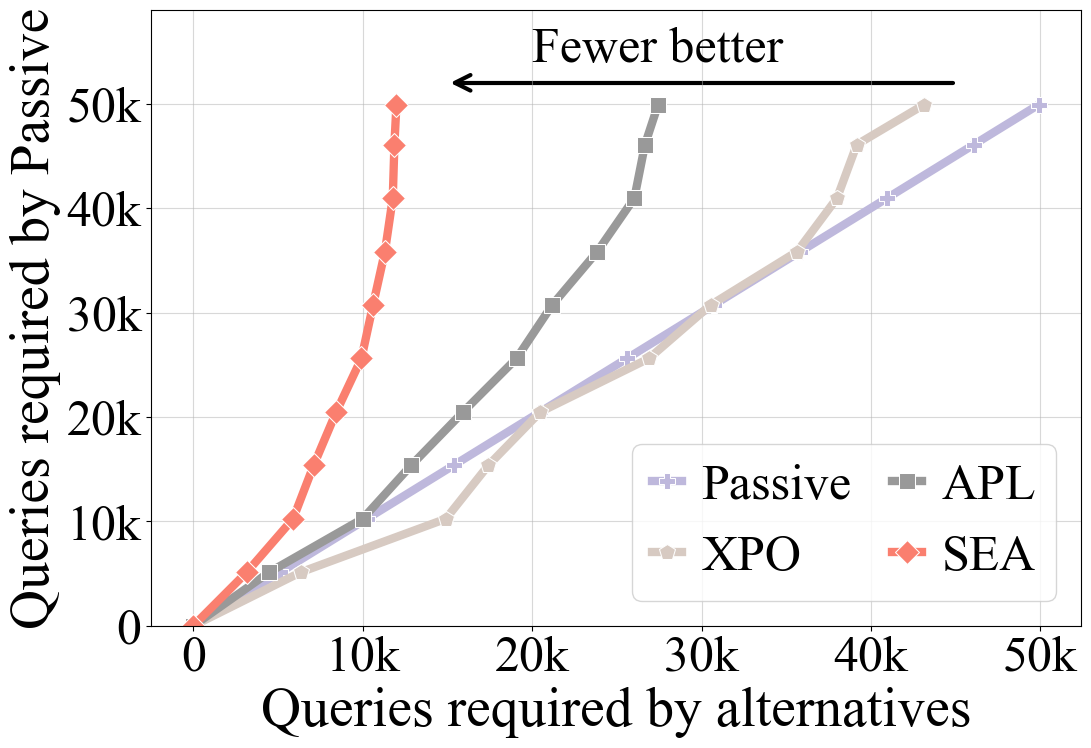

In [59]:
hue_order = [
    # "SFT",
    # "skyworkrm_dpo_offline",
    "skyworkrm_dpo_online",
    "skyworkrm_xpo",
    "skyworkrm_apl",
    "skyworkrm_dpo_sea",
]
methods_to_color = {
    # "SFT": "#8ECFC9",
    # "skyworkrm_dpo_offline": "#82b0d2",
    "skyworkrm_dpo_online": "#beb8dc",
    "skyworkrm_dpo_sea": "#fa7f6f",
    "skyworkrm_xpo": "#D7CAC2",
    "skyworkrm_apl": "#999999",
}
methods_to_labels= {
    # "SFT": "SFT",
    # "skyworkrm_dpo_offline": "Offline",
    "skyworkrm_dpo_online": "Passive",
    "skyworkrm_dpo_sea": "SEA",
    "skyworkrm_xpo": "XPO",
    "skyworkrm_apl": "APL",
}
methods_to_markers = {
    "SFT": "o",
    "Offline": "X",
    "skyworkrm_dpo_online": "P",
    "skyworkrm_dpo_sea": "D",
    "skyworkrm_xpo": "p",
    "skyworkrm_apl": "s"
}
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=df, x="method_query", y="ref_query", hue="method", style="method", linewidth=6, markersize=12, dashes=False, markers=methods_to_markers,palette=methods_to_color,hue_order=hue_order)
# plt.title("Sample complexity comparison", fontsize=48, y=1.0, pad=110)
plt.xlabel("Queries required by alternatives", fontsize=40)
# plt.ylabel("Win rate against reference responses\n(judged by preference oracle)", fontsize=15)
plt.ylabel("Queries required by Passive", fontsize=40)

ax.set_xticks([0, 10_000, 20_000, 30_000, 40_000, 50_000],
              ["0", "10k", "20k", "30k", "40k", "50k"])
ax.set_yticks([0, 10_000, 20_000, 30_000, 40_000, 50_000],
              ["0", "10k", "20k", "30k", "40k", "50k"])
ax.set_ylim(0, 59000)
              
sns.move_legend(
    ax, "best",
    # bbox_to_anchor=(.5, 1), 
    ncol=2, title=None, frameon=True,
    labels=[methods_to_labels[k] for k in hue_order],
    handletextpad=0.4,
    handlelength=0.6,
    columnspacing=0.8
)
plt.grid(True, which="both", ls="-", c="0.7", alpha=0.5)


from matplotlib.patches import FancyArrowPatch
arrow = FancyArrowPatch(
    (45000, 52000), (15000, 52000),
    mutation_scale=28,  # Controls arrow size
    arrowstyle='->',    # Arrow type
    connectionstyle="arc",
    color='black',       # Arrow color
    lw=3                # Line width
)
ax.add_patch(arrow)
ax.text(20000, 54000, "Fewer better")
fig = ax.get_figure()
fig.savefig("fig1_right.pdf", bbox_inches="tight")


In [63]:
mean["skyworkrm_dpo_sea"]

misc/query_step
0        0.498840
1960     0.517667
4600     0.603454
7240     0.662787
9880     0.720086
12520    0.776272
15160    0.813014
17800    0.837845
20440    0.851440
23080    0.861515
25720    0.866245
28360    0.876602
31000    0.882028
33640    0.890763
36280    0.889634
38920    0.891737
41560    0.891971
44200    0.893688
46840    0.897991
49480    0.895302
50008    0.894983
Name: eval/rm_win_rate_prob, dtype: float64